In [1]:
import pandas as pd
import numpy as np
import sys

In [2]:
config_path = '../config.yaml'
from scripts.dataloader import OnlineSpark
session = OnlineSpark(config_path,size='small')
session.path_dict

{'sut': {'root': 's3a://vasp-got-da/data/spark/rwup/sut/',
  'flc_obj': 's3a://vasp-got-da/data/spark/rwup/sut/record_id*flc*R5_object*',
  'vehicle': 's3a://vasp-got-da/data/spark/rwup/sut/record_id*vehicle*'},
 'avl_reference': {'root': 's3a://vasp-got-da/data/spark/rwup/avl_reference/',
  'ego': 's3a://vasp-got-da/data/spark/rwup/avl_reference/record_id*_ego_df*',
  'line': 's3a://vasp-got-da/data/spark/rwup/avl_reference/record_id*_line_df*',
  'object': 's3a://vasp-got-da/data/spark/rwup/avl_reference/record_id*_object_df*'}}

In [3]:
sys.path.append(r'/mnt/vasp-got-da/scripts/team_data_analytics/josefin/adas_mtd/')

In [4]:
import src.db.db_helper_dsl3 as dbh

In [5]:
def load_ego_sample(recording_id: str, time_interval: list=None) -> pd.DataFrame :
    '''
    Function load_ego_sample
    Usage: load ego data from spark
    Input: recording id, time interval: list[ptp_time_start, ptp_time_end]
        if time interval=None then load the whole record
    '''
    ego = session.loadParquet('avl_reference','ego',record_id=recording_id)
    if time_interval is not None:
        sample_time_range = [pd.to_datetime(time_interval[0], unit='s'),
                    pd.to_datetime(time_interval[1], unit='s')]
        print(sample_time_range)
        lc_sample = ego.filter(ego.ptp_time.between(time_interval[0],time_interval[1])).toPandas()
    else:        
        lc_sample = ego.toPandas()
    # lc_sample['ptp_time'] = pd.to_datetime(lc_sample['ptp_time'], unit='s')
    return lc_sample

In [44]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

def plot_yaw(lc_sample,):
    fig, ax1 = plt.subplots(figsize=(20,8))

    lc_sample['ptp_time'] = pd.to_datetime(lc_sample['ptp_time'], unit='s')

    color = 'tab:red'
    ax1.set_xlabel('ptp_time')
    ax1.set_ylabel('Yaw', color=color)
    ax1.plot(lc_sample['ptp_time'], lc_sample['Yaw'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # ax2 = ax1.twinx()  

    # color = 'tab:blue'
    # ax2.set_ylabel('YawRate', color=color)
    # ax2.plot(lc_sample['ptp_time'], lc_sample['YawRate'], color=color)
    # ax2.tick_params(axis='y', labelcolor=color)

    ax1.grid(which='major', color='#EEEEEE', linewidth=1.2)
    ax1.grid(which='minor', color='#EEEEEE', linewidth=0.6)
    ax1.minorticks_on()

    ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

    plt.title('Yaw and YawRate vs ptp_time')
    plt.show()

In [75]:
def find_lc(df, minimum=40, maximum=70):
    matching_ptp_times = []

    i = 0
    while i < len(df):
        current_yaw = df.loc[i, 'Yaw']
        current_ptp_time = df.loc[i, 'ptp_time']
        found_matching_pair = False

        # Check the next maximum rows
        for j in range(i + 1, min(i + maximum + 1, len(df))):
            if (abs(df.loc[j, 'Yaw'] - current_yaw) <= 0.001) and \
                (abs(df.loc[round((i+j)/2), 'Yaw'] - current_yaw)>0.015) and \
                (abs(df.loc[round((i+j)/2), 'Yaw'] - current_yaw)<0.1):
                # Check if the matching row is within the range
                if j >= i + minimum:
                    matching_pair = (current_ptp_time, df.loc[j, 'ptp_time'])
                    matching_ptp_times.append(matching_pair)
                    print(matching_pair)
                    i = i + 41 
                    found_matching_pair = True
                    break  # If a match is found, exit the inner loop
                else:
                    i += 1
                    break

        if not found_matching_pair:
            i += 1   
    return matching_ptp_times

In [47]:
test_sample=load_ego_sample('FH2467_20220328_170218',[1648489411.864, 1648489492.864])
# test_sample['Yaw'] = test_sample['Yaw'].apply(lambda x: abs(x) if x < 0 else x)

[Timestamp('2022-03-28 17:43:31.864000'), Timestamp('2022-03-28 17:44:52.864000')]


In [76]:
lc = find_lc(test_sample)

(1648489457.71, 1648489462.11)


In [49]:
# [(pd.to_datetime(start, unit='s'), pd.to_datetime(end, unit='s')) for start, end in [(1648489457.71, 1648489462.11)]]

In [50]:
# lc

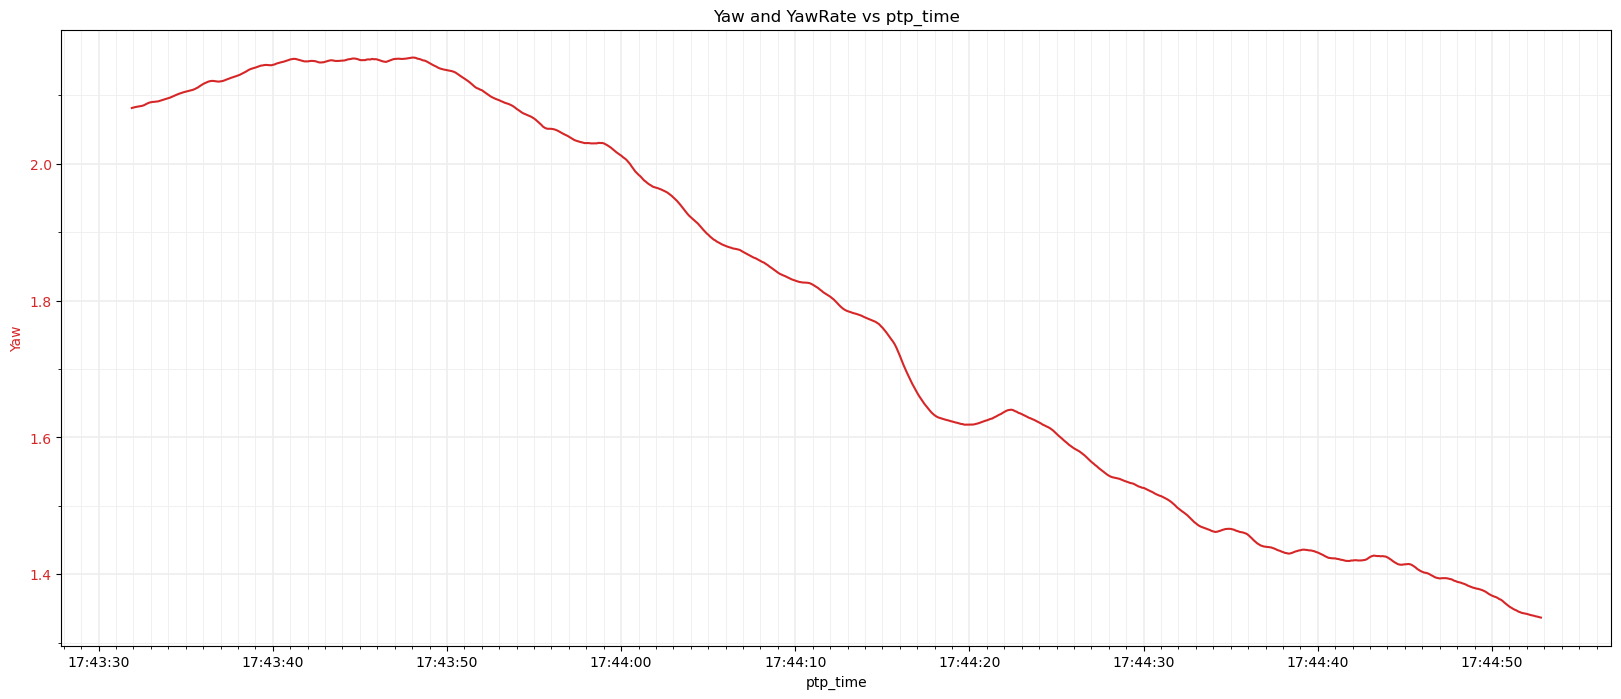

In [51]:
plot_yaw(test_sample)

In [53]:
gnss = dbh.read_db_to_df('gnss_country_and_cities', 'da_rwup')

Connection successful


In [6]:
ego_sample = load_ego_sample('FH2467_20220328_170218')
ego_sample.head(100)

,ptp_time,MessageNumber,ReferenceType,PositionX,PositionY,PositionZ,Roll,Pitch,Yaw,VelocityX,...,AccelerationX,AccelerationY,AccelerationZ,RollRate,PitchRate,YawRate,recording_id,vehicle,sw_version,__index_level_0__
0,1.648487e+09,0,Ego,0.001776,0.000494,0.000053,0.045791,0.129098,-1.646034,0.012933,...,-0.029202,0.068949,0.034317,-0.000891,0.004142,-0.001079,FH2467_20220328_170218,FH2467,1.1.11,75310
1,1.648487e+09,1,Ego,0.002970,0.000874,0.000232,0.045376,0.128911,-1.646103,0.011463,...,-0.016635,-0.021256,-0.007091,-0.001823,0.004287,0.000031,FH2467_20220328_170218,FH2467,1.1.11,75311
2,1.648487e+09,2,Ego,0.003903,0.001016,0.000429,0.045101,0.128876,-1.646216,0.006707,...,-0.068146,-0.069047,-0.009333,0.000380,0.001951,-0.002372,FH2467_20220328_170218,FH2467,1.1.11,75312
3,1.648487e+09,3,Ego,0.003993,0.000823,0.000527,0.045072,0.128951,-1.646278,-0.002835,...,-0.067344,0.046947,-0.072347,0.000705,-0.000738,-0.000686,FH2467_20220328_170218,FH2467,1.1.11,75313
4,1.648487e+09,4,Ego,0.003338,0.000913,0.000010,0.045351,0.128913,-1.646223,-0.006617,...,-0.045029,-0.003113,-0.041812,-0.000895,-0.003286,-0.000001,FH2467_20220328_170218,FH2467,1.1.11,75314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.648487e+09,95,Ego,0.001861,0.012156,-0.045641,0.046114,0.125214,-1.646519,-0.001802,...,0.046738,0.085947,0.039410,0.000455,-0.000805,-0.000489,FH2467_20220328_170218,FH2467,1.1.11,75405
96,1.648487e+09,96,Ego,0.001766,0.012222,-0.047231,0.046251,0.125227,-1.646523,-0.003523,...,-0.025551,0.046151,0.019787,0.000027,-0.001752,-0.000719,FH2467_20220328_170218,FH2467,1.1.11,75406
97,1.648487e+09,97,Ego,0.001686,0.012189,-0.048638,0.046370,0.125263,-1.646517,-0.002337,...,-0.012386,-0.018898,-0.014288,-0.000303,-0.001304,-0.000254,FH2467_20220328_170218,FH2467,1.1.11,75407
98,1.648487e+09,98,Ego,0.001701,0.012258,-0.050363,0.046448,0.125245,-1.646507,-0.000860,...,0.050247,-0.014215,0.004796,-0.000629,-0.000753,-0.000652,FH2467_20220328_170218,FH2467,1.1.11,75408


In [17]:
ego_sample['AccelerationZ'].max()

2.7527117051553915

In [25]:
ego_filter = ego_sample[(ego_sample['VelocityY']>15)&(abs(ego_sample['VelocityX'])<2)]

In [28]:
ego_filter

,ptp_time,MessageNumber,ReferenceType,PositionX,PositionY,PositionZ,Roll,Pitch,Yaw,VelocityX,VelocityY,VelocityZ,AccelerationX,AccelerationY,AccelerationZ,RollRate,PitchRate,YawRate,recording_id,vehicle,sw_version,__index_level_0__
22133,1648489151.91000008583,1134,Ego,-152.05571549275,963.61983789178,14.09186546598,-0.04388713357,0.10827233864,1.66472564571,-1.98509507036,19.77496790349,-1.35438104301,0.36030386000,0.37810314592,-0.73716417825,-0.01204135451,0.04179189970,-0.00374355072,FH2467_20220328_170218,FH2467,1.1.11,96338
22134,1648489152.00999999046,1135,Ego,-152.24804251641,965.60473067220,14.10602242593,-0.03869455819,0.11013667802,1.66512827969,-1.91781710037,19.79603847234,-1.56564416463,0.36435136393,0.21357819481,-0.66851562852,-0.02702251645,0.05295143368,0.00239857788,FH2467_20220328_170218,FH2467,1.1.11,96339
22135,1648489152.10999989510,1136,Ego,-152.43878991884,967.58955268702,14.11960842181,-0.03258019881,0.11262431000,1.66570753379,-1.88786086469,19.78042281427,-1.81336070324,0.11982779860,-0.23738733705,-0.88327142348,-0.03030353744,0.05702991033,-0.00584921671,FH2467_20220328_170218,FH2467,1.1.11,96340
22136,1648489152.21000003815,1137,Ego,-152.62905990350,969.57419889932,14.12773894798,-0.02720516700,0.11546838903,1.66554451935,-1.85625047339,19.76950445539,-2.04612197804,0.12557821250,0.10177449668,-0.51473924879,-0.03381005095,0.04802188225,-0.01265158899,FH2467_20220328_170218,FH2467,1.1.11,96341
22137,1648489152.30999994278,1138,Ego,-152.81851680420,971.55807316676,14.13302739430,-0.02245116322,0.11844359323,1.66557313060,-1.85313574698,19.73175206489,-2.21527033221,-0.27582147283,-0.28404067119,-0.00862404943,-0.03345394181,0.04411288996,-0.00326367517,FH2467_20220328_170218,FH2467,1.1.11,96342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25370,1648489475.60999989510,1371,Ego,4.35968499287,318.96240611235,6.17655188311,0.00845051516,0.09653989737,1.46128208973,1.98195092925,17.51973037003,-1.26079782864,0.41978484142,-0.16311567581,-0.07586064167,0.00028658902,0.01329917677,-0.01179101359,FH2467_20220328_170218,FH2467,1.1.11,119154
25372,1648489475.80999994278,1373,Ego,4.74638493115,322.44133195328,6.29795666132,0.01133984183,0.09818062861,1.46002875249,1.99358562524,17.46242751949,-1.35351283192,-0.01396230128,-0.13333409327,-0.13045359708,-0.00838069287,0.00854441489,-0.01007679247,FH2467_20220328_170218,FH2467,1.1.11,119156
25373,1648489475.91000008583,1374,Ego,4.93962891394,324.17555200960,6.35889991745,0.01140703187,0.09895596953,1.45903643780,1.98288168333,17.41716881151,-1.35861362013,-0.28820518799,-0.30648022914,-0.05746296106,-0.00528557550,-0.00301462057,-0.01359749754,FH2467_20220328_170218,FH2467,1.1.11,119157
25374,1648489476.00999999046,1375,Ego,5.13279341307,325.90700029163,6.41852659453,0.01000035558,0.09954107496,1.45715375322,1.97831707928,17.38424058384,-1.33225280244,0.07696759323,-0.16000321427,0.00306254515,-0.00981616138,-0.01556555444,-0.01556584532,FH2467_20220328_170218,FH2467,1.1.11,119158


In [22]:
abs(ego_filter['VelocityX']).min()

0.0005751334989761976

In [3]:
def dtp(datetime): #datetime to ptp time
    return pd.to_datetime(datetime,unit='ns').timestamp()

def ptd(ptp_time): #ptptime to datetime
    return pd.to_datetime(ptp_time,unit='s')

In [11]:
ptd(1647349380)

Timestamp('2022-03-15 13:03:00')

In [4]:
dtp('2022-02-18 14:01:16.899530')

1645192876.89953

In [56]:
def transcor(ego_sample: pd.DataFrame):
    modified_sample = ego_sample.copy()  
    for index, sample in ego_sample.iterrows(): #[(ego_sample['MessageNumber'] > 2995) | (ego_sample['MessageNumber'] < 5)].iterrows():
        if index > 0:  
            prev_row = ego_sample.loc[index - 1]
            if (abs(sample['PositionX'] - prev_row['PositionX']) > 20 or
                abs(sample['PositionY'] - prev_row['PositionY']) > 20):
                prev_prev_row = ego_sample.loc[index - 2]
                for idx, next_sample in ego_sample.loc[index:].iterrows():
                    modified_sample.at[idx, 'PositionX'] = prev_row['PositionX']*1.5 - prev_prev_row['PositionX']*0.5 + modified_sample.at[idx, 'PositionX']
                    modified_sample.at[idx, 'PositionY'] = prev_row['PositionY']*1.5 - prev_prev_row['PositionY']*0.5 + modified_sample.at[idx, 'PositionY']
                    modified_sample.at[idx, 'PositionZ'] = prev_row['PositionZ']*1.5 - prev_prev_row['PositionZ']*0.5 + modified_sample.at[idx, 'PositionZ']
    return modified_sample


In [57]:
new_ego = transcor(ego_sample)

In [5]:
pd.set_option('display.max_columns', 50)

In [58]:
pd.set_option('display.max_rows', 130)

In [27]:
pd.set_option('display.float_format', lambda x: '%.11f' % x)

In [59]:
def cal_angle(ego_sample):
    ego_sample['angle'] = pd.Series(dtype=float)
    for index, sample in ego_sample.iloc[5:].iterrows():
        ego_sample.at[index, 'angle'] = np.arctan2(ego_sample.at[index, 'PositionY'] - ego_sample.at[index-5, 'PositionY'], ego_sample.at[index, 'PositionX'] - ego_sample.at[index-5, 'PositionX'])        
    for index, sample in ego_sample.iloc[:5].iterrows():
        ego_sample.at[index, 'angle'] = ego_sample.at[5, 'angle']
    return ego_sample

In [60]:
new_ego = cal_angle(new_ego)
new_ego

,ptp_time,MessageNumber,ReferenceType,PositionX,PositionY,PositionZ,Roll,Pitch,Yaw,VelocityX,...,AccelerationY,AccelerationZ,RollRate,PitchRate,YawRate,recording_id,vehicle,sw_version,__index_level_0__,angle
0,1648486938.60999989510,0,Ego,0.00177629699,0.00049416767,0.00005271845,0.04579117222,0.12909821896,-1.64603371678,0.01293309316,...,0.06894871166,0.03431742981,-0.00089107150,0.00414223681,-0.00107859151,FH2467_20220328_170218,FH2467,1.1.11,75310,0.51187365485
1,1648486938.71000003815,1,Ego,0.00296996109,0.00087418780,0.00023218617,0.04537633834,0.12891071690,-1.64610297743,0.01146349806,...,-0.02125613521,-0.00709137034,-0.00182327825,0.00428717803,0.00003075164,FH2467_20220328_170218,FH2467,1.1.11,75311,0.51187365485
2,1648486938.80999994278,2,Ego,0.00390259112,0.00101578794,0.00042905286,0.04510085925,0.12887618021,-1.64621631690,0.00670680288,...,-0.06904689672,-0.00933252485,0.00038039451,0.00195110458,-0.00237233270,FH2467_20220328_170218,FH2467,1.1.11,75312,0.51187365485
3,1648486938.91000008583,3,Ego,0.00399330293,0.00082331570,0.00052741356,0.04507222858,0.12895138919,-1.64627838384,-0.00283455223,...,0.04694738609,-0.07234708608,0.00070548824,-0.00073771383,-0.00068635996,FH2467_20220328_170218,FH2467,1.1.11,75313,0.51187365485
4,1648486939.00999999046,4,Ego,0.00333776913,0.00091257319,0.00000985153,0.04535080457,0.12891328814,-1.64622334467,-0.00661743553,...,-0.00311260009,-0.04181165822,-0.00089542377,-0.00328582434,-0.00000134936,FH2467_20220328_170218,FH2467,1.1.11,75314,0.51187365485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36371,1648490575.71000003815,372,Ego,-11977.55944792947,-4214.47060176521,-53.37249869294,0.01048899689,0.12576068857,1.95560098386,0.00355812410,...,-0.11366459263,0.08728347832,-0.00020774225,0.00061755799,-0.00081746489,FH2467_20220328_170218,FH2467,1.1.11,15039,1.23006285169
36372,1648490575.80999994278,373,Ego,-11977.55929299482,-4214.46994726988,-53.37297183089,0.01054700711,0.12576383624,1.95557803238,-0.00023521029,...,-0.08660658025,0.03912959208,0.00053794956,0.00044897948,-0.00202488252,FH2467_20220328_170218,FH2467,1.1.11,15040,1.22925185297
36373,1648490575.91000008583,374,Ego,-11977.55935455163,-4214.46933877026,-53.37346609309,0.01051030109,0.12576743582,1.95559374081,-0.00166656630,...,0.09266297338,-0.06076979077,0.00088367370,-0.00002411033,0.00086043035,FH2467_20220328_170218,FH2467,1.1.11,15041,1.30621326611
36374,1648490576.00999999046,375,Ego,-11977.55948788897,-4214.46876456519,-53.37377999909,0.01044283953,0.12582276714,1.95564486112,-0.00049170852,...,0.04620202572,-0.01789729290,-0.00080811417,-0.00107252353,0.00212961739,FH2467_20220328_170218,FH2467,1.1.11,15042,1.40973916577


In [61]:
test_sample=load_ego_sample('FH2467_20220328_170218',[1648489411.864, 1648489500.864])

[Timestamp('2022-03-28 17:43:31.864000'), Timestamp('2022-03-28 17:45:00.864000')]


In [62]:
test_sample

,ptp_time,MessageNumber,ReferenceType,PositionX,PositionY,PositionZ,Roll,Pitch,Yaw,VelocityX,...,AccelerationX,AccelerationY,AccelerationZ,RollRate,PitchRate,YawRate,recording_id,vehicle,sw_version,__index_level_0__
0,1648489411.91000008583,734,Ego,-96.89091269736,171.92127921479,0.66460621543,-0.03416257691,0.09594154149,2.08171020435,-8.67156146890,...,-0.46641338041,0.64490173095,-0.23297869390,-0.00281846864,0.00012763425,0.00627963093,FH2467_20220328_170218,FH2467,1.1.11,118517
1,1648489412.00999999046,735,Ego,-97.77104744181,173.45712649869,0.72793117445,-0.03397398802,0.09649602736,2.08247067769,-8.70872832730,...,-0.37429049962,0.60759633585,-0.33814284476,-0.00708557753,-0.00177162631,0.00683170006,FH2467_20220328_170218,FH2467,1.1.11,118518
2,1648489412.10999989510,736,Ego,-98.65457750321,175.00090981042,0.77222190425,-0.03387159717,0.09754076923,2.08307420038,-8.74376241987,...,-0.33488071718,0.30516970066,0.00994408238,-0.01033247125,-0.00383940798,0.01049667101,FH2467_20220328_170218,FH2467,1.1.11,118519
3,1648489412.21000003815,737,Ego,-99.54103019729,176.54942377238,0.80657668971,-0.03399114680,0.09839806657,2.08352263163,-8.77052184358,...,-0.24184231237,0.20244727244,0.00251428829,-0.00552042353,-0.00744833428,-0.00170579315,FH2467_20220328_170218,FH2467,1.1.11,118520
4,1648489412.30999994278,738,Ego,-100.43022820202,178.10079538263,0.84290741663,-0.03415334082,0.09859210246,2.08408459013,-8.78901635688,...,-0.00982054018,0.27005466326,0.23024165472,-0.00018851319,0.00035084433,0.00675470677,FH2467_20220328_170218,FH2467,1.1.11,118521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,1648489500.41000008583,1619,Ego,123.21155564202,747.37152207643,9.08011380583,-0.00693625935,0.10197033905,0.78798417105,13.91280543727,...,0.70719279251,0.20120700724,-0.20554058719,0.02174605196,0.04106037729,-0.03442702064,FH2467_20220328_170218,FH2467,1.1.11,119402
886,1648489500.50999999046,1620,Ego,124.60941160942,748.75620213198,9.07903664000,-0.00299078098,0.10337859794,0.78519377708,13.97686528964,...,0.60295264751,0.36861597868,-0.17624461466,0.01464816028,0.03407036253,-0.03261290876,FH2467_20220328_170218,FH2467,1.1.11,119403
887,1648489500.60999989510,1621,Ego,126.01131339272,750.14303483861,9.07765304390,-0.00087160094,0.10475680176,0.78269626275,13.99832512722,...,0.21318776779,0.24176559783,0.15078672130,0.00235625828,0.02084039025,-0.02098648618,FH2467_20220328_170218,FH2467,1.1.11,119404
888,1648489500.71000003815,1622,Ego,127.41507010616,751.53166764230,9.07745682076,-0.00080785217,0.10531222613,0.77992129932,14.01029878672,...,0.05751511962,0.22560231682,0.47429527681,-0.00681230601,-0.00133546380,-0.02811662285,FH2467_20220328_170218,FH2467,1.1.11,119405


In [63]:
def sample_process(ego_sample):
    return cal_angle(transcor(ego_sample))

In [64]:
testing = sample_process(test_sample)

In [65]:
ptd(1648489462.61)

Timestamp('2022-03-28 17:44:22.609999872')

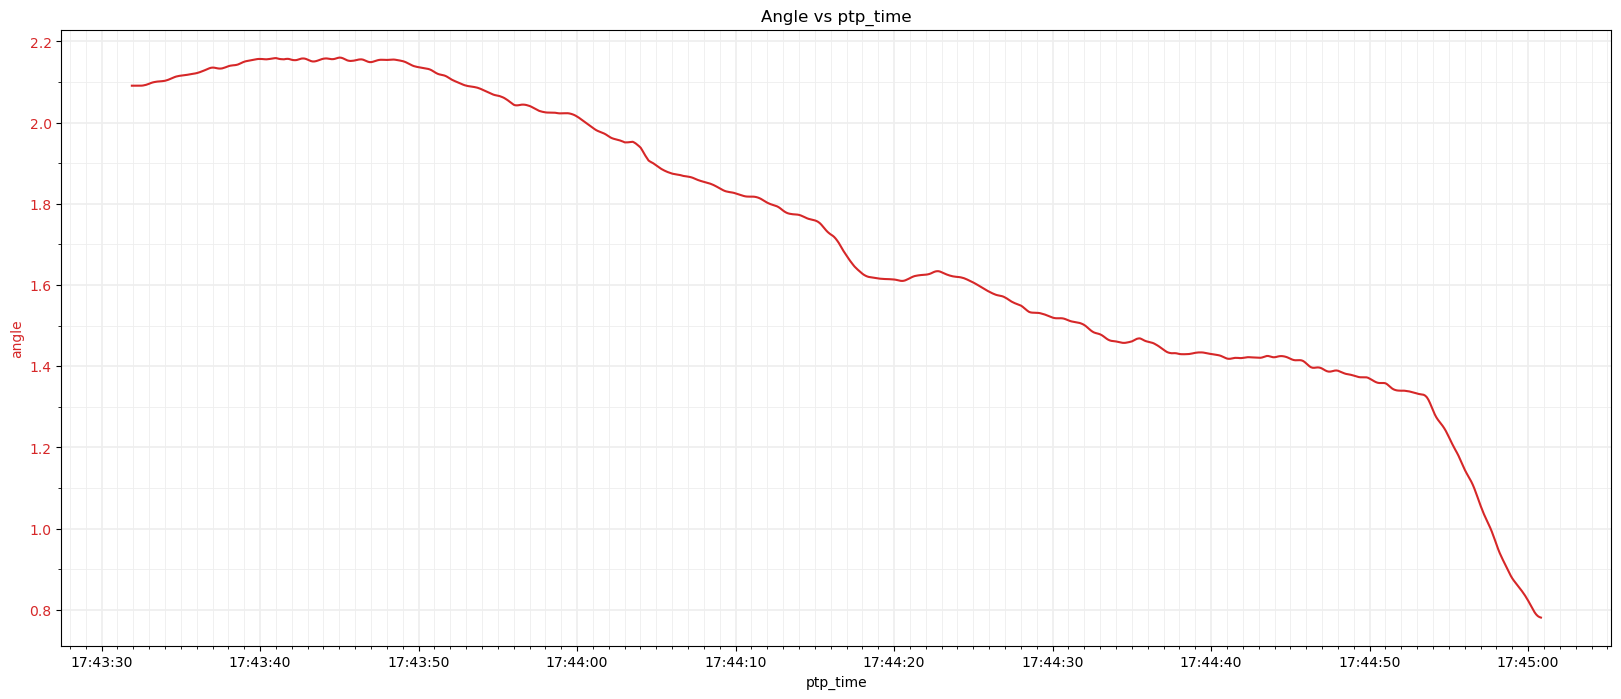

In [66]:
plot_angle(testing)

In [80]:
def load_and_find(recording_id: str, time_interval: list=None):
    sample = sample_process(load_ego_sample(recording_id, time_interval))
    lc = find_lc(sample)
    return sample, lc

In [69]:
def load_line(recording_id: str, time_interval: list=None):
    line = session.loadParquet('avl_reference','line',record_id=recording_id)
    line_sample = line.filter(line.ptp_time.between(time_interval[0],time_interval[1])).toPandas()
    return line_sample

In [ ]:
testline=load_line('FH2369_20220218_133112',[1645192050.499, 1645192150.498])

In [ ]:
testline

,ptp_time,MessageNumber,ReferenceType,TrackingID,SensorIDList,Type,Color,BoundaryLineX,BoundaryLineY,BoundaryLineZ,recording_id,vehicle,sw_version,__index_level_0__
0,1645192050.50999999046,778,Line,17.00000000000,100.00000000000,3.00000000000,3.00000000000,"[-219.7884063720703, -215.8457794189453, -211....","[9.635359764099121, 9.116909980773926, 8.46576...","[-2.79457950592041, -2.841923952102661, -2.886...",FH2369_20220218_133112,FH2369,1.1.7,6736
1,1645192050.50999999046,778,Line,14.00000000000,100.00000000000,4.00000000000,3.00000000000,"[-225.62176513671875, -222.73361206054688, -21...","[16.517900466918945, 16.13761329650879, 15.741...","[-2.6807682514190674, -2.7211012840270996, -2....",FH2369_20220218_133112,FH2369,1.1.7,6737
2,1645192050.50999999046,778,Line,19.00000000000,100.00000000000,3.00000000000,3.00000000000,"[-134.74932861328125, -134.0249481201172, -133...","[11.066533088684082, 10.7860746383667, 10.6108...","[-3.232337474822998, -3.224574327468872, -3.21...",FH2369_20220218_133112,FH2369,1.1.7,6738
3,1645192050.50999999046,778,Line,35.00000000000,100.00000000000,0.00000000000,0.00000000000,"[-148.50735473632812, -144.45721435546875, -14...","[8.036578178405762, 7.717402935028076, 7.51697...","[-3.2714083194732666, -3.2622640132904053, -3....",FH2369_20220218_133112,FH2369,1.1.7,6739
4,1645192050.50999999046,778,Line,21.00000000000,100.00000000000,0.00000000000,0.00000000000,"[-101.01619720458984, -99.86758422851562, -99....","[-1.8402961492538452, -1.9121477603912354, -1....","[-3.5122358798980713, -3.5097830295562744, -3....",FH2369_20220218_133112,FH2369,1.1.7,6740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12593,1645192150.41000008583,1777,Line,23.00000000000,100.00000000000,4.00000000000,3.00000000000,"[146.6891326904297, 136.94271850585938, 127.32...","[15.07654857635498, 13.683792114257812, 12.308...","[1.1500990390777588, 0.729692280292511, 0.4105...",FH2369_20220218_133112,FH2369,1.1.7,19329
12594,1645192150.41000008583,1777,Line,69.00000000000,100.00000000000,0.00000000000,0.00000000000,"[-138.03489685058594, -136.64454650878906, -13...","[13.414009094238281, 13.341230392456055, 13.26...","[-6.801002502441406, -6.7823357582092285, -6.7...",FH2369_20220218_133112,FH2369,1.1.7,19330
12595,1645192150.41000008583,1777,Line,71.00000000000,100.00000000000,0.00000000000,0.00000000000,"[150.0204620361328, 148.8736114501953, 147.970...","[19.480796813964844, 19.329334259033203, 19.21...","[1.3176997900009155, 1.2648392915725708, 1.220...",FH2369_20220218_133112,FH2369,1.1.7,19331
12596,1645192150.41000008583,1777,Line,70.00000000000,100.00000000000,0.00000000000,0.00000000000,"[-18.41082763671875, -17.53024673461914, -16.6...","[6.930816173553467, 6.854133129119873, 6.84808...","[-4.285922527313232, -4.264089584350586, -4.24...",FH2369_20220218_133112,FH2369,1.1.7,19332


In [97]:
def if_cross(BoundaryX, BoundaryY, PositionX, PositionY, buffer_distance=0.5):
    line_points = [(x, y) for x, y in zip(BoundaryX, BoundaryY)]
    if len(line_points) < 2:
        return False
    boundary_line = LineString(line_points)
    buffered_line = boundary_line.buffer(buffer_distance)
    union_buffer = unary_union([buffered_line])
    is_in_buffer = union_buffer.contains(Point(PositionX, PositionY))
    return is_in_buffer

In [102]:
from shapely.geometry import Point, LineString
from shapely.ops import unary_union
def find_cross(recording_id: str, time_interval: list=None):
    ego_sample = load_ego_sample(recording_id, time_interval)
    line_sample = load_line(recording_id, time_interval)
    for index, ego_position in ego_sample.iterrows():
        PositionX = ego_position['PositionX']
        PositionY = ego_position['PositionY']
        ego_time = ego_position['ptp_time']
        for idx, line in line_sample[line_sample['ptp_time']>ego_time].iterrows():
            if if_cross(line['BoundaryLineX'], line['BoundaryLineY'], PositionX, PositionY):
                return True
    return False

In [81]:
lcs = load_and_find('FH2369_20220218_133112',[1645191319.499, 1645192882.498])

[Timestamp('2022-02-18 13:35:19.499000064'), Timestamp('2022-02-18 14:01:22.497999872')]
(1645192110.01, 1645192114.51)
(1645192122.11, 1645192129.11)
(1645192181.41, 1645192187.11)
(1645192185.61, 1645192191.61)
(1645192203.71, 1645192210.71)
(1645192207.81, 1645192214.71)
(1645192211.91, 1645192218.01)
(1645192227.01, 1645192231.91)
(1645191820.11, 1645191827.01)
(1645191847.21, 1645191854.21)
(1645191873.11, 1645191879.81)


In [82]:
lcs[1]

[(1645192110.01, 1645192114.51),
 (1645192122.11, 1645192129.11),
 (1645192181.41, 1645192187.11),
 (1645192185.61, 1645192191.61),
 (1645192203.71, 1645192210.71),
 (1645192207.81, 1645192214.71),
 (1645192211.91, 1645192218.01),
 (1645192227.01, 1645192231.91),
 (1645191820.11, 1645191827.01),
 (1645191847.21, 1645191854.21),
 (1645191873.11, 1645191879.81)]

In [83]:
def check_cross(recording_id:str, time_intervals:list):
    

SyntaxError: invalid syntax (69995892.py, line 1)

In [103]:
check_lc = find_cross('FH2369_20220218_133112', (1645192110.01, 1645192114.51))

[Timestamp('2022-02-18 13:48:30.009999872'), Timestamp('2022-02-18 13:48:34.509999872')]


In [104]:
print(check_lc)

False


In [6]:
ptd(1648730066.21)

Timestamp('2022-03-31 12:34:26.210000128')